# Uncertainty in drought indicators in the ERA5–Drought dataset

Production date: 2026-02-xx

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Dataset version: 1.0.

Produced by: Enis Gerxhalija, Olivier Burggraaff (National Physical Laboratory).

## 🌍 Use case: Use case listed here in full 

## ❓ Quality assessment question
* **In most cases there should be one question listed here in bold**
* **(In some cases a second related/follow-up question may be included)**

**‘Context paragraph’ (no title/heading)** - a very short introduction before the assessment statement describing approach taken to answer the user question. One or two key references could be useful,  if the assessment summarises literature . These can be referenced directly in the text, like `[Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2)` giving: [Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2). For major references numerical labels like this should be used (which should also listed at the end) `Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2))`giving: Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2)). Please use DOI links where possible.


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology

A ‘free text’ introduction to the data analysis steps or a description of the literature synthesis, with a justification of the approach taken, and limitations mentioned. **Mention which CDS catalogue entry is used, including a link, and also any other entries used for the assessment**.

Followed by a numbered list of the methodology and results, with the same headings as the sections under ‘Analysis and Results’. These should be links to the sections below, using the format `[](section-label)`. The title of the section will be automatically populated, so no need to repeat the title of the section when referecing it like this.

```{note}
The section labels for the links need to be manually set, as seen below (`(section-1)=`, followed by the heading). These labels will be shown in GitHub but will not appear when the Jupyter Book page is built.
```

* These headings can be specific to the quality assessment, and help guide the user through the ‘story’ of the assessment. This means we cannot pre-define the sections and headings here, as they will be different for each assessment.
* Sub-bullets could be used to outline what will be done/shown/discussed in each section
* The list below is just an example, or may need more or fewer sections, with different headings

E.g. 'The analysis and results are organised in the following steps, which are detailed in the sections below:' 

**[](section-codesetup)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-spi)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

<!-- **[](section-spei)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-4)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.
 
**[](section-5)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings. -->

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data. Because earthkit is in active development, some functionality may change after this notebook is published. If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [2]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Analysis
import calendar
from scipy import stats

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

import geopandas as gpd
import regionmask

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

# Type hints
from typing import Callable, Iterable, Optional
from scipy.stats import rv_continuous as Distribution
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

#### Helper functions
This section defines some functions and variables used in the following analysis, allowing code cells in later sections to be shorter and ensuring consistency.

##### Data (pre-)processing

The following functions restructure the ensemble members in the ERA5–Drought dataset along a new dimension, as in ERA5:

In [24]:
def add_number_dimension(data: xr.Dataset, *, n_members: int=10,
                         time_dimension: str="time", ensemble_dimension: str="number") -> xr.Dataset:
    """
    Convert a dataset
    from ERA5–Drought format (10-duplicate `time` dimension)
    to ERA5 format (`number` dimension for ensemble members)
    """
    # Find unique times and use these to generate datasets for successive members
    member_numbers = np.arange(n_members)
    _, index = np.unique(data[time_dimension], return_index=True)
    data = [data.isel({time_dimension: index + i}) for i in member_numbers]

    # Combine into one dataset
    data = xr.concat(data, dim=ensemble_dimension).assign_coords(number=member_numbers)

    # Rechunk for memory efficiency
    data = data.chunk({ensemble_dimension: n_members, time_dimension: 48, "lat": 360, "lon": 103,})

    return data

def request_data_for_one_site(*, lat, lon, half_width=0.25):
    """ Return a CDS request for a bounding box around a point (lon, lat). """
    north, south = lat + half_width, lat - half_width
    east , west  = lon + half_width, lon - half_width
    box = [north, west, south, east]
    box = [round(x, 2) for x in box]  # Round all coordinates to 2 digits
    request_box = {"area": box}
    return request_box

##### Filter data with quality flags

In [4]:
def apply_quality_mask(sig, index_ds):
    """
    Apply a monthly quality mask to a drought index dataset.
    Aligns mask and data by month and sets values outside the mask to NaN.
    """

    # 12‑month mask -> month dimension
    sig_m = sig.assign_coords(
        month=("time", sig.time.dt.month.values)
    ).swap_dims({"time": "month"}).drop_vars("time")

    # add month to drought dataset
    index_ds = index_ds.assign_coords(
        month=index_ds.time.dt.month
    )

    # broadcast mask
    mask_full = sig_m.sel(month=index_ds.month)

    # apply
    return index_ds.where(mask_full == 1)
  

##### Accumulation periods
The following cells contain constants and functions used in accumulating variables (e.g. precipitation) over time:

In [5]:
# Define constants such as the accumulation periods to use
MONTHS = range(1, 13)  # January to December (inclusive)
EARTHRADIUS = 6371  # earth radius [km]

##### Visualisation
The following cells contain functions for plotting results, starting with some base helper functions (e.g. displaying in Jupyter Notebook or Jupyter Book style, adding textboxes with consistent formatting, etc.):

In [8]:
_style_spi =        {"cmap": plt.cm.RdBu,    "vmin": -3, "vmax": 3,   "extend": "both"}
_style_spi_spread = {"cmap": plt.cm.cividis, "vmin": 0,  "vmax": 1.5, "extend": "max"}

styles = {
    "SPI_mean": Style(**_style_spi), "SPI_spread": Style(**_style_spi_spread),
}

# Apply general settings
for style in styles.values():
    style.normalize = False

In [10]:
def decorate_fig(fig: ekp.Figure, *, title: Optional[str]="") -> None:
    """ Decorate an earthkit figure with land, coastlines, etc. """
    # Add progress bar because individual steps can be very slow for large plots
    with tqdm(total=4, desc="Decorating", leave=False) as progressbar:
        fig.land()
        progressbar.update()
        fig.coastlines()
        progressbar.update()
        # fig.borders()
        # progressbar.update()
        fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
        progressbar.update()
        fig.title(title)
        progressbar.update()

In [9]:
def plot_stacked(ax, df, ylabel):
    bottom = np.zeros(len(df.index))
    handles = []

    for i, sev in enumerate(severities):
        bar = ax.bar(
            df.index, df.iloc[:, i],
            facecolor=mycollisthex[i + 1],
            alpha=1,
            width=relativedelta.relativedelta(months=1),
            label=sev,
            bottom=bottom,
            align='edge'
        )
        handles.append(bar)
        bottom += df.iloc[:, i]

    # Axis formatting
    ax.set_ylabel(ylabel, size=11)
    ax.margins(x=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', colors='dimgrey')
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=10)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='lightgray', linestyle='solid', linewidth=0.8)
    ax.set_ylim([0, 100])

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    return handles

def plot_ens_index_timeseries(dataarray, title="SPI12 — time series for each ensemble member", ylim = 8, xaxis = "time",
                             color = None):
    """
    Plot a time series of SPI (or any variable) for each ensemble member.
    """

   # Create fig and ax properly
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot using xarray's built-in plotting, but explicitly target the axis
    dataarray.plot.line(
        x=xaxis,
        hue='number',
        add_legend=True,
        ax=ax,
        color = color
    )

    # Styling
    ax.set_title(title)
    ax.set_ylim([-ylim, ylim])
    ax.set_xlabel("Time")
    ax.set_ylabel(str(dataarray.name))
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    return fig, ax


def plot_spread(mean_da: xr.DataArray, spread_da: xr.DataArray, xaxis = "time",
                title: str = "SPI-12 Mean with Shaded Spread"):

    da_lo = mean_da - spread_da
    da_hi = mean_da + spread_da

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.fill_between(
        mean_da[xaxis].values,
        da_lo.values,
        da_hi.values,
        label="±1 ST.D",
    )

    ax.set_ylabel(mean_da.name)
    ax.set_ylim([-8, 8])
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    fig.tight_layout()

    return fig, ax

def plot_stacked_spi_ensemble(filtered_cats, filtered_counts, CATEGORIES_SPI,
                              color_map, ylabel = "Ensemble count", title = "SPI12 - Stacked Ensemble Bar Chart"):
    """
    Plot stacked ensemble drought classification per timestamp.
    """
    plt.figure(figsize=(16, 6))
    used = set()  # to avoid duplicate legend entries

    for i, (t, cat_arr, count_arr) in enumerate(zip(x, filtered_cats, filtered_counts)):
        bottom = 0
        for cat, cnt in zip(cat_arr, count_arr):
            # skip forced-zero placeholder and zero/negative counts
            if (cat == 0) or (cnt is None) or (cnt <= 0):
                continue

            label = CATEGORIES_SPI[cat-1][2]
            plt.bar(
                i, int(cnt),
                bottom=bottom,
                color=color_map.get(cat, "#cccccc"),
                width=1.0,        
                align="center",
                linewidth=0,        
                label=label if label not in used else ""
            )
            used.add(label)
            bottom += int(cnt)
    
    plt.xticks([])
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Category")
    plt.tight_layout()
    plt.show() #TODO : Fractionalise by # of succesful members.

The following cell contains functions for geospatial plots:

In [11]:
def geospatial_plot_mean_spread(data_mean: xr.Dataset, data_spread: xr.Dataset, indicator: str, date: str, *,
                                domain: Optional[AnyDomain]=None,
                                glue_label: Optional[str]=None) -> ekp.Figure:                   
    """
    Plot the mean and spread (pre-calculated) of an ensemble at a given time geospatially.
    """
    # Select data
    data_mean_spread = [data.sel({"time": date}) for data in (data_mean, data_spread)]

    # Determine if SPI or SPEI
    spi_or_spei = "SPEI" if "E" in indicator else "SPI"

    # Create figure
    fig = ekp.Figure(rows=1, columns=2, size=(8, 4))

    # Plot data
    for data, stat in zip(data_mean_spread, ["mean", "spread"]):
        # Plot data
        subplot = fig.add_map(domain=domain)
        subplot.grid_cells(data, style=styles[f"{spi_or_spei}_{stat}"])

        # Colour bar
        subplot.legend(location="bottom", label=f"{indicator} ({stat})")

    # Decorate figures
    decorate_fig(fig)
    fig.title(f"ERA5–Drought ensemble statistics on {date} in {domain}")
    
    # Show result
    plt.show()
    plt.close()

def calculate_gridarea(lats_centr, res, nlon):

    lats1 = (lats_centr + (res / 2)) * np.pi / 180  # np.sin requires radians
    lats2 = (lats_centr - (res / 2)) * np.pi / 180
    areas = (
        (np.pi / 180) * (EARTHRADIUS ** 2) * np.abs(np.sin(lats1) - np.sin(lats2)) * res
    )

    ## overwrite any areas of 0 (at the poles) with np.NaN to prevent problems
    areas[np.where(areas == 0.0)] = np.nan  
    # return array of dimension nlat x nlon
    area_2d = np.swapaxes(np.tile(areas, (nlon, 1)), 0, 1)
    return area_2d
    
def rename_era5_dimensions(data: xr.Dataset) -> xr.Dataset:
    """
    Rename dimensions
    from ERA5 (valid_time, latitude, longitude)
    to ERA5–Drought (time, lat, lon)
    format.
    """
    data = data.rename({"valid_time": "time",
                        "latitude": "lat",
                        "longitude": "lon",
                       })
    return data

def longitude_360_to_180(data: xr.Dataset, longitude_dimension="lon") -> xr.Dataset:
    """ Convert longitude from 0..360 to -180..180 format. """
    longitude_new = ((data[longitude_dimension] - 180) % 360) - 180
    data = data.assign_coords({longitude_dimension: longitude_new})
    data = data.sortby(longitude_dimension)#.squeeze()
    return data

In [12]:
ID_ERA5_LANDSEAMASK = "reanalysis-era5-single-levels"

request_landsea_mask = {
    "product_type": "reanalysis",
    "variable": "land_sea_mask",
    "date": "2000-01-01",  # Does nothing but is required in CDS form
    "time": "00:00",       # Does nothing but is required in CDS form
    "format": "netcdf",
    "download_format": "zip",
}

# Download mask
LAND = ekd.from_source("cds", ID_ERA5_LANDSEAMASK, request_landsea_mask)
LAND = LAND.to_xarray(compat="equals")  # Convert to xarray dataset

# Convert longitude from 0..360 to –180..180
LAND = rename_era5_dimensions(LAND)
LAND_FRAC = longitude_360_to_180(LAND, "lon")

# Drop time dimension
LAND_FRAC = LAND_FRAC.squeeze("time")

# Convert to boolean mask: Land if > 0.5 (following ERA5 convention)
LAND = (LAND_FRAC["lsm"] > 0.5) # Land considered to be full

(section-spi)=
### 2. The ERA5–Drought ensemble: SPI & SPEI

#### 2.1 Download data 
In this assessment,
we will calculate an estiamte of the SPI and SPEI uncertainty for each month
(with different accumulation periods, see below)
for the years 1940–2024 from the ERA5-Drought ensemble dataset.

In [13]:
# Define your preferred analysis and reference periods
years = (1940, 2024)  # Years for the analysis (inclusive)

Having defined our target years, we can now define our CDS request.
First, we define templates with some default parameters
(e.g. years, data format)
that will also be used later in the notebook.
Additional information for specific downloads
(e.g. variable, data stream)
is mixed into this template where relevant.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.
If you prefer not to use earthkit, the following requests can also be used with the [cdsapi module](https://cds.climate.copernicus.eu/how-to-api#linux-use-client-step).
In either case (earthkit-data or cdsapi), it is required to set up a CDS account and API key as explained [on the CDS website](https://cds.climate.copernicus.eu/how-to-api).

In [51]:
ID_ERA5_DROUGHT = "derived-drought-historical-monthly"

# Main template
request_era5drought_template = {
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "year": [f"{year}" for year in range(years[0], years[1]+1)],
    "month": [f"{month:02}" for month in MONTHS],
}

AUS_AREA = {"area": [-5, 109, -45, 159]} # AUSTRALIA AREA

# ---- Components by product type ----
PRODUCT_REANALYSIS = {"product_type": ["reanalysis"]} 
PRODUCT_ENSEMBLE   = {"product_type": ["ensemble_members"]}

# ---- Request by product type ----=
request_era5drought_reanalysis = PRODUCT_REANALYSIS | AUS_AREA | request_era5drought_template
request_era5drought_ensemble   = PRODUCT_ENSEMBLE   | AUS_AREA | request_era5drought_template

# ---- Components by variable type ----=
VARS      = ["standardised_precipitation_index", "standardised_precipitation_evapotranspiration_index"] 
SPI_FLAG_VARS = ["test_for_normality_spi", "probability_of_zero_precipitation_spi"] 
SPEI_FLAG_VARS =  ["test_for_normality_spei"]

# ---- Components by accumulation period ----
ACC_1  = {"accumulation_period": ["1"]}
ACC_12 = {"accumulation_period": ["12"]}
ACC_6 = {"accumulation_period": ["6"]}

# Build subrequests for ensemble product
aus_subrequests_ens_12 = [request_era5drought_ensemble | ACC_12 | {'variable': [var]} for var in VARS]
aus_subrequests_ens_1 = [request_era5drought_ensemble | ACC_1 | {'variable': [var]} for var in VARS] 

# Build subrequests for SPI ensemble quality flag product
aus_subrequests_ens_spi_flag_12 = [request_era5drought_ensemble | ACC_12 | {'variable': [var]} for var in SPI_FLAG_VARS]
aus_subrequests_ens_spi_flag_1 = [request_era5drought_ensemble | ACC_1 | {'variable': [var]} for var in SPI_FLAG_VARS] 

# Build subrequests for SPEI ensemble quality flag product
aus_subrequests_ens_spei_flag_12 = [request_era5drought_ensemble | ACC_12 | {'variable': [var]} for var in SPEI_FLAG_VARS] 
aus_subrequests_ens_spei_flag_1 = [request_era5drought_ensemble | ACC_1 | {'variable': [var]} for var in SPEI_FLAG_VARS] 

Unlike ERA5, ERA5–Drought does not come with a `number` dimension representing the ensemble members.
Instead, they are accessible via the `time` dimension, which has 10 entries (representing the 10 members) at each point in time.
For convience, we re-organise the dataset to include a `number` dimension:

In [60]:
def ens_drought_request(ekd_request):
    """ Take multiple accumulation period request for ensemble data and combine into one dataset. """
    file_paths = [fld.path for fld in ekd_request._indexes] # Extract file paths from the Earthkit FieldList
    datasets = [xr.open_dataset(path) for path in file_paths] # Open each file as xarray
    processed = [add_number_dimension(ds) for ds in datasets] #  Add the number dimension to each dataset
    final = xr.combine_by_coords(processed, join = "outer", combine_attrs="drop") # Stack all datasets together
    final = final.chunk({"time": -1}) # Rechunk to single time dimension
    return final 

def load_era5drought_data(subrequests_era5drought, product_type = "ens"):
    """
    Retrieve ERA5 Drought data from CDS via Earthkit,
    convert to xarray, and add the 'number' dimension.
    """
    if product_type == "ens":
        ds = ekd.from_source("cds", ID_ERA5_DROUGHT, *subrequests_era5drought)
        ds = ens_drought_request(ds)
    else: 
        ds = ekd.from_source("cds", ID_ERA5_DROUGHT, *subrequests_era5drought)
        ds = ds.to_xarray(compat="equals")  # Convert to xarray dataset
    return ds

In [ ]:
# load SPI/SPEI12 ensemble data and SPI12 quality flags.
ds_ens_12 = load_era5drought_data(aus_subrequests_ens_12)
spi_flag_ens_12 = load_era5drought_data(aus_subrequests_ens_spi_flag_12)

# load SPI/SPEI1 ensemble data and SPI1 quality flags.
ds_ens_1 = load_era5drought_data(aus_subrequests_ens_1)
spi_flag_ens_1 = load_era5drought_data(aus_subrequests_ens_spi_flag_1)

In [ ]:
# load SPEI12/SPEI1 ensemble quality flags separately.
spei_flag_ens_12 = load_era5drought_data(aus_subrequests_ens_spei_flag_12)
spei_flag_ens_1 = load_era5drought_data(aus_subrequests_ens_spei_flag_1)

Below we apply the quality mask ERA5-Drought provides to all ensemble members.

In [ ]:
P_ZERO_THRESH = 0.1 # set threshold for pzero quality flag.

sig_spi12 = xr.where(spi_flag_ens_12['significance'] == 1, 1, 0)  # set spi12 flag xarrays
p0_spi12  = xr.where(spi_flag_ens_12['pzero'] <= P_ZERO_THRESH, 1, 0) # TODO: Make pzreo threshold a constant declared at the start.

sig_spi1 = xr.where(spi_flag_ens_1['significance'] == 1, 1, 0)  # TODO: Don't need to use xr.where
p0_spi1  = xr.where(spi_flag_ens_1['pzero'] <= P_ZERO_THRESH, 1, 0) # set spi 1 flag xarrays

spi12 = ds_ens_12["SPI12"]
spi1 = ds_ens_1["SPI1"]

spi12_sig_masked = apply_quality_mask(sig_spi12, spi12) # apply significance masking
spi1_sig_masked = apply_quality_mask(sig_spi1, spi1)

spi12_masked = apply_quality_mask(p0_spi12, spi12_sig_masked) # apply pzero masking
spi1_masked = apply_quality_mask(p0_spi1, spi1_sig_masked) 

The mean and standard deviation across filtered ensemble members is then calculated for SPI1 & SPI12.

In [ ]:
era5drought_ensemble_spi_mean_12, era5drought_ensemble_spi_spread_12 = ensemble_mean_and_spread(spi12_masked)
era5drought_ensemble_spi_mean_1, era5drought_ensemble_spi_spread_1 = ensemble_mean_and_spread(spi1_masked)

Below is a spatial plot of the mean and standard deviation across all 10 ensemble members for a single timestamp.

In [ ]:
geospatial_plot_mean_spread(era5drought_ensemble_spi_mean_12, era5drought_ensemble_spi_spread_12, "SPI12", "2024-05-01",
                            domain="Australia")

In [ ]:
geospatial_plot_mean_spread(era5drought_ensemble_spi_mean_1, era5drought_ensemble_spi_spread_1, "SPI1", "2024-05-01",
                            domain="Australia")

Next, we define location of interest (Tibooburra, New South Wales, Australia).

In [22]:
example_site = {"lat": -29.25, "lon": 142.00}  # Compatible with ERA5–Drought.

Along with a drought-severity list for categorising SPI/SPEI indices.

In [ ]:
CATEGORIES_SPI = [  # Approximates the GDO scheme
    (   2.00, 100,     "Extremely wet",            "#7a007b"),  # deepest purple 
    (   1.50,   2.00,  "Severely wet",             "#af51c3"),  # dark purple
    (   1.00,   1.50,  "Moderately wet",           "#eaccf8"),  # medium purple
    (   0.00,   1.00,  "Near‑normal / mildly wet", "#ffffff"),  # white
    (  -1.00,   0.00,  "Near‑normal / mildly dry", "#ffffff"),  # white
    (  -1.50,  -1.00,  "Moderately dry",           "#fffc03"),  # yellow
    (  -2.00,  -1.50,  "Severely dry",             "#feaa00"),  # orange
    (-100,     -2.00,  "Extremely dry",            "#ff0100"),  # red
]
CATEGORIES_SPEI = [
    (   2.33, 100,    "Extremely wet",  "#01148b"),  # very dark navy
    (   1.65,   2.33, "Severely wet",   "#1871de"),  # strong blue
    (   1.28,   1.65, "Moderately wet", "#14acf4"),  # medium blue
    (   0.84,   1.28, "Mildly wet",     "#00f2fe"),  # cyan
    (  -0.84,   0.84, "Near-normal",    "#9afa93"),  # light green
    (  -1.28,  -0.84, "Mildly dry",     "#fdc403"),  # yellow
    (  -1.65,  -1.28, "Moderately dry", "#f2631d"),  # orange
    (  -2.33,  -1.65, "Severely dry",   "#df2929"),  # red
    (-100,     -2.33, "Extremely dry",  "#8c1b1a"),  # dark red
]

#### 2.2 Ensemble SPI time series in example site (Tibooburra, New South Wales, Australia).
We analyse the time series of all 10 ensemble members for the single site.

In [ ]:
spi_da = spi12_masked.sel(**example_site)  # select the DataArray for SPI12.
plot_ens_index_timeseries(spi_da)

Next we categorise each ensemble member in the SPI time series for the example site.

In [350]:
da_cat = categorise_dataset(spi_da, CATEGORIES_SPI) # categorise each ensemble member.

This obtains a drought classification time series for all 10 ensemble members.

In [351]:
unique_vals, counts_per_timestamp = get_unique_counts_per_timestamp(da_cat)

Next we filter the counts so we only look at dry event (defined as moderately dry or higher).

In [352]:
filtered_cats, filtered_counts = get_filtered_counts_per_timestamp(counts_per_timestamp, unique_vals)

The plot below shows the number of ensemble members that fall into each category per timestamp.

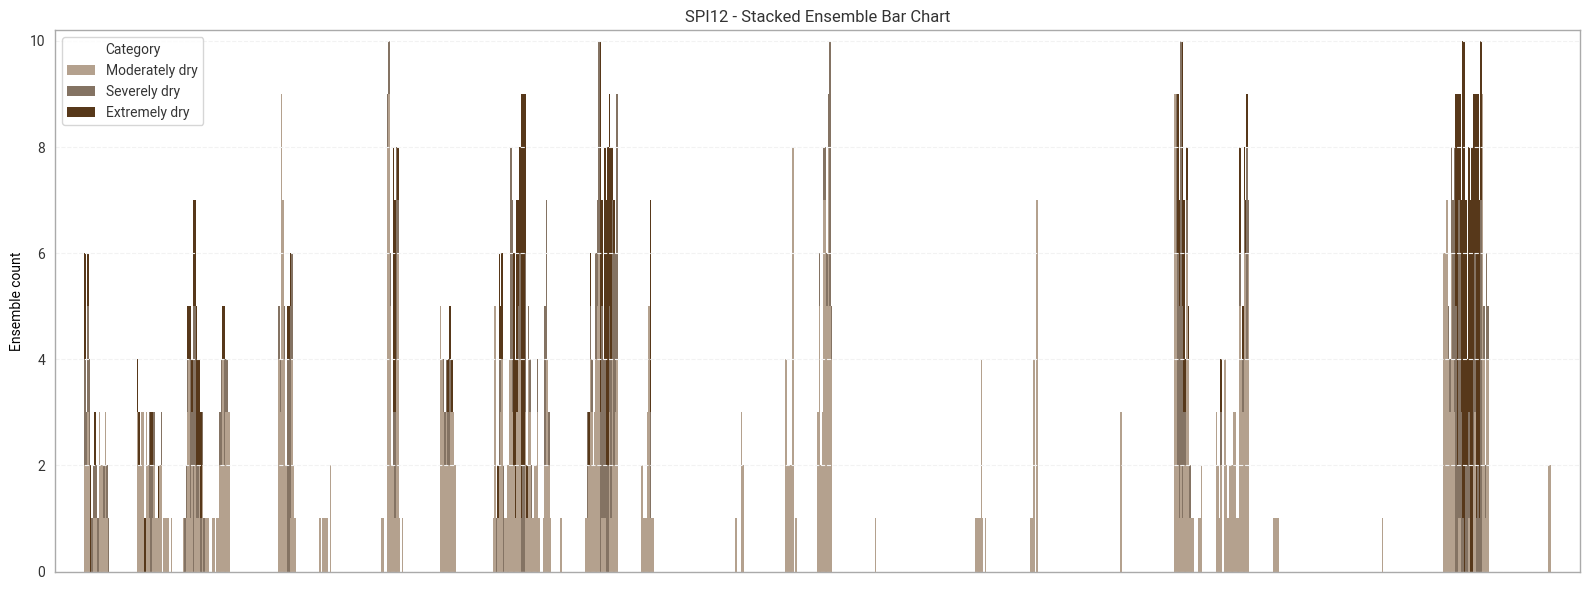

In [353]:
color_map = {
    6: "#B4A18E",   # Moderate
    7: "#847363",   # Severe
    8: "#57381A",   # Extreme
}

plot_stacked_spi_ensemble(filtered_cats, filtered_counts, CATEGORIES_SPI, color_map)

#### Ensemble SPEI time series in example site (Tibooburra, New South Wales, Australia).

The same is done for above, but this time for the SPEI ensemble.

In [308]:
sig_spei12 = xr.where(spei_flag_ens_12['significance'] == 1, 1, 0)  # set spi12 flag xarrays
sig_spei1 = xr.where(ds_flag_ens_1['significance'] == 1, 1, 0)  # TODO: Don't need to use xr.where

spei12 = ds_ens_12["SPEI12"]
spei1 = ds_ens_1["SPEI1"]

In [322]:
spei12_masked = apply_quality_mask(sig_spei12, spei12) 
spei1_masked = apply_quality_mask(sig_spei1, spei1) # apply significance masking

<Figure size 1200x600 with 0 Axes>

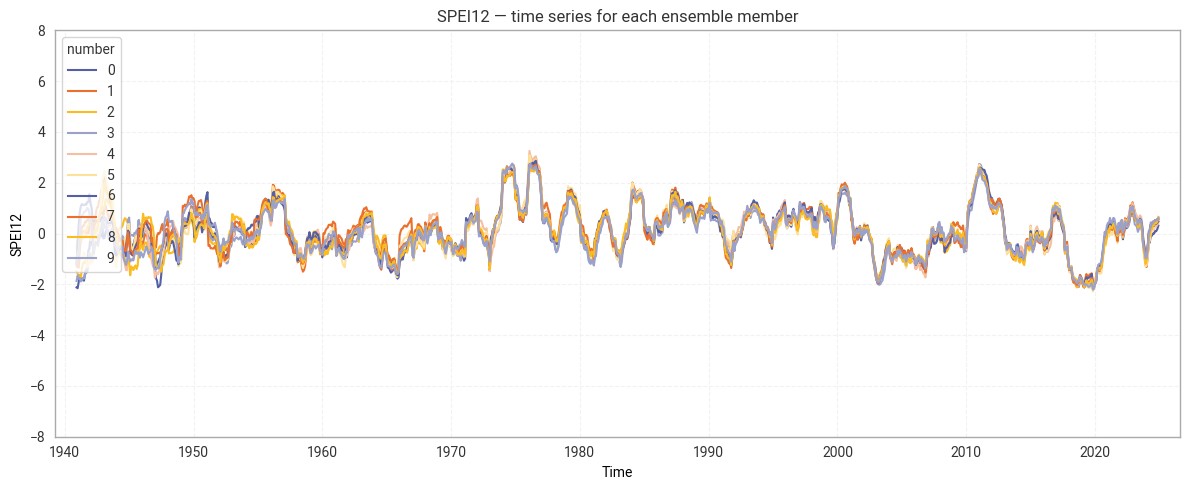

In [328]:
spei_site = spei12_masked.sel(**example_site)  # select the DataArray

plot_ens_index_timeseries(spei_site, title = 'SPEI12 — time series for each ensemble member') # TODO, put reanalysis in between.

The mean & spread for the SPEI time series in the example site is then computed and plotted.

In [330]:
era5drought_ensemble_spei_mean_12, era5drought_ensemble_spei_spread_12 = ensemble_mean_and_spread(spei12_masked)

In [ ]:
spei_da_mean = era5drought_ensemble_spei_mean_12.sel(**example_site)
spei_da_spread = era5drought_ensemble_spei_spread_12.sel(**example_site)

fig, ax = plot_spread(spei_da_mean, spei_da_spread, title = 'SPEI-12 Mean with Shaded Spread"')

#### Development of a Parametric Insurance Product for Rice in Central Java (Indonesia).

Based on the drought indices and the decision to use the time span of the drought indices that best explains volatility in rice production, a parametric insurance product can be developed. A parametric insurance contract that is based on weather indices (such as SPI for example) is fully defined through the sum insured, the trigger (also called strike), the limit and the modality of the pay-out function. [[World Bank Group +18.]](http://hdl.handle.net/10986/29784)

Triggers, limits, and the modality of the pay-out function are integral parts of the "Indemnity Function", where the parametric insurance contract protects against insufficient and/or excessive realisations of the underlying weather variable (e.g., rainfall deficit quantified through SPI).

The Indemnity Function, $I$ that is based on the SPI is defined as: 

$$
I = f(SPI \mid x, Tr, Ex) = x \times f(x) =
\begin{cases}
0, & \text{if } SPI > Tr, \\[6pt]
\dfrac{Tr - SPI}{Tr - Ex}, & \text{if } Ex < SPI \le Tr, \\[10pt]
1, & \text{if } SPI \le Ex.
\end{cases}
$$

where $x$ is the sum insured, $Tr$ is the Trigger and $Ex$ is the Exit below which level pay-outs stop. Based on the sum insured, a tick size may be determined that consists of a monetary pay-out for each increment of the SPI index. 

Parametric insurance products have previously been developed by the World Bank for "wet season rice" and 4-months cumulative SPIs (January-April) for the Central Java region in Indonesia. In that study, the insured value of a ton of rice was set to USD 100, with the total theoretical sum insured set to USD 520,162,600. The trigger for a parametric insurance payout to start was taken to be -5, with an exit of an SPI value of -20 justified from historical rainfall data and climate projections. Indemnity would occur under the parametric insurance product for a total of 15 SPI values. For the study, a tick value of USD 6,666,667 was determined from the maximum production shortfall of 1 million tons, with the payout limit defined as USD 100,000,000.

The ERA5‑Drought product, which provides an estimate of uncertainty based on the 10‑member ensemble at a fine resolution, can be directly integrated into the design and evaluation of parametric insurance schemes. Incorporating this ensemble spread offers an explicit quantification of uncertainty around the underlying drought indicator, such as SPI, and therefore around potential payouts. 

Below, we assess using the ERA5-Drought reanalysis and ensemble product to provide an estimate of the uncertainty in parametric insurance contract payouts. This enables insurers to better assess risk, refine calculations, and understand the robustness of the parametric insurance contract. It allows parametric insurance to be extended to regions where in-situ observations are sparse, and strengthens the feasibility of deploying scalable insurance products underpinned by weather data worldwide.

Download data for Central Java region:

In [56]:
INDO_SITE = {"lat": -29.25, "lon": 142.00}  # Compatible with ERA5–Drought.
INDO_LABEL_SITE = f"({INDO_SITE['lat']:.2f} °N, {INDO_SITE['lon']:.2f} °E)"
INDO_AREA = request_data_for_one_site(lat=INDO_SITE["lat"], lon=INDO_SITE["lon"])

# ---- Request by product type ----=
indo_request_era5drought_reanalysis = PRODUCT_REANALYSIS | INDO_AREA | request_era5drought_template
indo_request_era5drought_ensemble   = PRODUCT_ENSEMBLE   | INDO_AREA | request_era5drought_template

# Build subrequests for ensemble SPI/SPEI product
subrequests_ens_6 = [indo_request_era5drought_ensemble | ACC_6 | {'variable': [var]} for var in VARS]
subrequests_ens_spi_flag_6 = [indo_request_era5drought_ensemble | ACC_6 | {'variable': [var]} for var in SPI_FLAG_VARS]
subrequests_ens_spei_flag_6 = [indo_request_era5drought_ensemble | ACC_6 | {'variable': [var]} for var in SPEI_FLAG_VARS]

# Build subrequests for SPI reanalysis product
subrequests_rean_6 = [indo_request_era5drought_reanalysis | ACC_6 | {'variable': [var]} for var in VARS] 
subrequests_rean_spi_flag_6 = [indo_request_era5drought_reanalysis | ACC_6 | {'variable': [var]} for var in SPI_FLAG_VARS] 
subrequests_rean_spei_flag_6 = [indo_request_era5drought_reanalysis | ACC_6 | {'variable': [var]} for var in SPEI_FLAG_VARS] 

In [ ]:
# Submit requests for Ensemble SPI6 data.
indo_ds_ens_6 = load_era5drought_data(subrequests_ens_6).sel(**INDO_SITE)
indo_ds_spi_flag_ens_6 = load_era5drought_data(subrequests_ens_spi_flag_6).sel(**INDO_SITE)

  0%|          | 0/2 [00:00<?, ?it/s]

2026-02-17 13:46:16,756 WARNING [2025-10-30T00:00:00] Downloading data from this dataset requires that the user be registered with the CDS. The use of the API requires a CDS API key.
2026-02-17 13:46:16,758 INFO Request ID is 0997a5b1-1704-4983-964d-6fed4c00e1b2
2026-02-17 13:46:16,762 WARNING [2025-10-30T00:00:00] Downloading data from this dataset requires that the user be registered with the CDS. The use of the API requires a CDS API key.
2026-02-17 13:46:16,764 INFO Request ID is d9c95953-1863-4353-8389-72339cfb97cc
2026-02-17 13:46:16,829 INFO status has been updated to accepted
2026-02-17 13:46:16,830 INFO status has been updated to accepted
2026-02-17 13:46:30,402 INFO status has been updated to running
2026-02-17 13:46:30,582 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attempt 1 of 500
Retrying in 120 seconds
Recovering from connection error [HTTPSC

25ce0df1894235196bb380eb1d4fc769.zip:   0%|          | 0.00/31.7M [00:00<?, ?B/s]

2026-02-17 14:51:49,727 INFO status has been updated to successful


4df71718231eb236ea3a30ff5315bcf4.zip:   0%|          | 0.00/31.6M [00:00<?, ?B/s]

  0%|          | 0/1015 [00:00<?, ?it/s]

  0%|          | 0/1015 [00:00<?, ?it/s]

In [58]:
# Submit requests for Ensemble SPEI6 Flag data.
indo_ds_spei_flag_ens_6 = load_era5drought_data(subrequests_ens_spei_flag_6).sel(**INDO_SITE)

2026-02-17 14:54:15,072 INFO status has been updated to successful


beced2f122e34111744d7c005d4447a7.zip:   0%|          | 0.00/429k [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [61]:
# Submit requests for Reanalysis SPI/SPEI6 data.
indo_ds_rean_6 = load_era5drought_data(subrequests_rean_6, "rean")
indo_ds_rean_spi_flag_6 = load_era5drought_data(subrequests_rean_spi_flag_6, "rean")
indo_ds_rean_spei_flag_6 = load_era5drought_data(subrequests_rean_spei_flag_6, "rean")

  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt



Quality masks are then applied from Shapiro-Wilks significance testing and the probability of zero precipitation. 

In [ ]:
def extract_flags(ds_flag, p_zero_thresh):
    sig = (ds_flag['significance'] == 1)
    p0  = (ds_flag['pzero'] <= p_zero_thresh)
    return sig, p0


sig6, p06 = extract_flags(indo_ds_flag_ens_6, P_ZERO_THRESH)
sig1, p01 = extract_flags(indo_ds_flag_ens_1, P_ZERO_THRESH)

spi6 = indo_ds_ens_6["SPI6"]
spi1 = indo_ds_ens_1["SPI1"]

spi6_sig = apply_quality_mask(sig6, spi6)
spi1_sig = apply_quality_mask(sig1, spi1)

indo_spi6_masked = apply_quality_mask(p06, spi6_sig)
indo_spi1_masked = apply_quality_mask(p01, spi1_sig)

Select Location in Central Java Mask

In [ ]:
indo_site_spi_mean_6, indo_site_spi_spread_6 = ensemble_mean_and_spread(indo_single_site)

In [ ]:
def aggregate_months(ds, n_months=4, time_axis = "time"):
    """
    Aggregates the first N calendar months of each year 
    by summing over the selected months.
    """
    
    agg_ds = ds.sel(time = ds[time_axis].dt.month.isin(range(n_months))) # select first N months.
    agg_ds = agg_ds.groupby("time.year").sum("time") # Sum over first N months.
    
    return agg_ds

indo_first4_single_site = aggregate_months(indo_single_site)

In [ ]:
fig, ax = plot_ens_index_timeseries(c_first4_sum, "Aggregate Ensemble SPI6 - Averaged over Central Java", 30, "year")

In [ ]:
c_first4_sum = c_first4_sum.sel(year = slice(1960, 2024))

def payout_function(agg_ds, threshold = 5, tick_size = 6666667, money_unit = 1e6): 
    """
    Computes capped payouts based on deviation from a threshold and derives
    ensemble mean and standard deviation.
    """

    abs_diff = abs(agg_ds - threshold) # Deviation from threshold
                    
    payout = abs_diff*(tick_size/money_unit) # Payout from deviation 
        
    capped_payout = payout.where(~(payout > 100), 100) # Cap at USD 100 mn.
    
    payout_mean = capped_payout.mean("number") # Calculate mean payout from ensemble.
    payout_std = capped_payout.std("number") # Calculated std payout from ensemble.
    
    payout_mean =  payout_mean.fillna(0) # Fill NaNs with zeros
    payout_std =  payout_std.fillna(0)

    return payout_mean, payout_std

payout_mean, payout_std = payout_function(c_first4_sum)

In [ ]:
series = payout_mean.to_series()
errors = payout_std.to_series()

da = c_first4_sum.sel(year=slice(1960, 2024))

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- ENSEMBLE MEMBERS ALL BLACK ---
# Remove hue, loop through members manually
for m in da['number'].values:
    ax1.plot(
        da['year'].values,
        da.sel(number=m).values,
        color='black',
        linewidth=1.2,
        alpha=0.9,
        zorder=5   # <-- ENSURE THEY ARE ABOVE THE BAR PLOT
    )

ax1.set_title("Aggregate Ensemble SPI6 - for single location in Central Java")
ax1.set_xlabel("Year")
ax1.set_ylabel(str(da.name) if da.name else "SPI6")
ax1.set_ylim([-30, 30])
ax1.grid(True, alpha=0.3)

# Keep axis visible above ax2
ax1.set_zorder(5)
ax1.patch.set_alpha(0)   # <-- transparent background so bars show behind it

ax2 = ax1.twinx()
ax2.set_ylabel("Payout (million USD)")

# Make bar axis sit behind the line axis
ax2.set_zorder(1)

# Use the same x-limits as the main axis
ax2.set_xlim(ax1.get_xlim())

x = series.index
y = series.values
yerr = errors.reindex(series.index).values
money_color = "#2ecc71"
# --- BAR PLOT BEHIND! ---
ax2.bar(
    x, y,
    yerr=yerr,
    color= money_color,
    edgecolor="black",
    capsize=4,
    ecolor="black",
    zorder=1  
)

ax2.grid(False)

line_handle = ax1.lines[0]
bar_handle = ax2.bar(
    [0], [0],
    color=money_color,
    edgecolor="black",
    alpha=0.5
)[0]

ax1.legend(
    [line_handle, bar_handle],
    ["Ensemble SPI6 members", "Insurance payout (mean ± std)"],
    loc="upper right"
)

fig.tight_layout()
plt.show()

#### Regional: Importing EM-DAT.

Data for natural disasters freely available: https://public.emdat.be/data Downloaded below for Australia only.

In [ ]:
df_droughts = pd.read_excel('public_emdat_custom_request_2026-02-10_4d6d0e90-816f-47b2-b19c-9529760cde15.xlsx') 

# Fill missing months with 1 so the interval is still plottable
df_droughts["Start Month"] = df_droughts["Start Month"].fillna(1).astype(int)
df_droughts["End Month"]   = df_droughts["End Month"].fillna(12).astype(int)

df_droughts["start_ts"] = pd.to_datetime(
    df_droughts["Start Year"].astype(int).astype(str) + "-" +
    df_droughts["Start Month"].astype(str) + "-01"
)

df_droughts["start_ts"] = pd.to_datetime(
    df_droughts["Start Year"].astype(int).astype(str)
    + "-"
    + df_droughts["Start Month"].astype(str)
    + "-01"
)

df_droughts["end_ts"] = pd.to_datetime(
    df_droughts["End Year"].astype(int).astype(str)
    + "-"
    + df_droughts["End Month"].astype(str)
    + "-01" )


#### Area mask for Australia
ADMIN regions were downloaded from: https://www.naturalearthdata.com/downloads/

In [245]:
area_2d = calculate_gridarea(LAND.lat, res=abs(LAND.lat[1]-LAND.lat[0]), nlon=len(LAND.lon))*LAND
area_2d = xr.DataArray(area_2d, coords={'lat': LAND.lat,'lon': LAND.lon}, dims=["lat", "lon"])
#area_2d.plot()

In [ ]:
adminid     = "AU1"
geoshp = gpd.read_file('ne_10m_admin_0_countries_lakes.shp')
adminshpa = geoshp.loc[ (geoshp.SOV_A3 == adminid), 'geometry' ]
adminshpa=adminshpa.to_crs('EPSG:4326')
adminshpa = adminshpa.union_all()
# 5. Wrap into a clean GeoDataFrame with index = 0
adminshpa = gpd.GeoDataFrame(
    {"name": ["Australia"], "geometry": [adminshpa]},
    crs="EPSG:4326"
)

adminmask = regionmask.mask_geopandas(adminshpa, era5drought_ensemble_spi_mean.lon, era5drought_ensemble_spi_mean.lat)
adminmask_xr = xr.DataArray(adminmask, coords={'lat': era5drought_ensemble_spi_mean.lat, 'lon': era5drought_ensemble_spi_mean.lon}, dims=["lat", "lon"])
adminmask_xr = adminmask_xr.where( np.isnan(adminmask_xr.values), 1) # to set the 0 from regionmask to 1
adminmask_3d_xr = adminmask_xr.expand_dims(dim={"time": era5drought_ensemble_spi_mean.time}, axis=0)

Again the mean, standard deviation (spread) for the ensemble SPI are calculated across all Australia

In [ ]:
era5drought_ensemble_spi_mean, era5drought_ensemble_spi_spread = ensemble_mean_and_spread(era5drought_ensemble_spi_aus)

In [ ]:
# calculate area in drought, over all ensemble members.
area_2d_adj = area_2d * LAND_FRAC

area_2d_adj = area_2d_adj.reindex(lat=era5drought_ensemble_spi_aus.lat,lon=era5drought_ensemble_spi_aus.lon, method="nearest")
area_2d_adj = area_2d_adj.drop_vars(["number", "expver","time"])
area_3d_adj = area_2d_adj.expand_dims(time = era5drought_ensemble_spi_aus.time, number =era5drought_ensemble_spi_aus.number )

mean_aid_spi = {}
std_aid_spi = {}

window = 12
swindow=f"w{window}"
mean_aid_spi[swindow] = {}
std_aid_spi[swindow] = {}

mylevels     = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000]
mycollisthex = ['#bebebe','#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']

for severity in ['moderate','severe','extreme','any']:

    if severity == "mild":
        thresh_min, thresh_max = -1, 0
    elif severity == "moderate":
        thresh_min, thresh_max = -1.5, -1
    elif severity == "severe":
        thresh_min, thresh_max = -2, -1.5
    elif severity == "extreme":
        thresh_min, thresh_max = -999, -2
    elif severity == "any":
        thresh_min, thresh_max = -999, -1

    # pre‑compute drought mask
    rspi  = era5drought_ensemble_spi_aus["SPI12"] * adminmask_3d_xr
    dmask = xr.where((rspi > thresh_min) & (rspi <= thresh_max) & (rspi != -9999),
                     1, np.nan)

    # pre‑compute denominators once for all ensemble members
    denom = (adminmask_3d_xr * area_3d_adj).sum(["lat", "lon"])

    # compute numerators vectorized
    num   = (dmask * area_3d_adj).sum(["lat", "lon"])

    # drought % for all ensemble members at once
    result = 100 * num / denom   # shape: (number,)

    std_result = result.std(dim="number") #TODO: Take reanalysis, and calculate # ensemble members that do not fall into same category.
    mean_result = result.mean(dim="number")
    
    mean_aid_spi[swindow][severity] = mean_result.to_pandas() 
    std_aid_spi[swindow][severity] = std_result.to_pandas()

In [ ]:
# --- FIGURE SETUP ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4), sharex=True)

title1 = r"$\bf{" + f"{string.ascii_lowercase[0]}" + "}$"
fig.suptitle(
    f"{title1} | Percent of Australia in drought (SPI-{window}) over ensemble members.",
    fontsize=18, y=0.97
)

plt.rc('font', family='sans-serif', weight='normal', size=16)

severities = ['extreme', 'severe', 'moderate']

mean_apidata = pd.concat([
    mean_aid_spi[f'w{window}']['extreme'],
    mean_aid_spi[f'w{window}']['severe'],
    mean_aid_spi[f'w{window}']['moderate']
], axis=1)

std_apidata = pd.concat([
    std_aid_spi[f'w{window}']['extreme'],
    std_aid_spi[f'w{window}']['severe'],
    std_aid_spi[f'w{window}']['moderate']
], axis=1)


# --- APPLY TO SUBPLOTS ----------------------------------------------------

handles1 = plot_stacked(ax1, mean_apidata, "Mean [%]")
handles2 = plot_stacked(ax2, std_apidata, "Stdev. [%]")

# --- SHARED LEGEND --------------------------------------------------------

fig.legend(
    handles1,
    severities,
    title="Drought Severity",
    title_fontsize=12,
    ncol=len(severities),
    loc="lower center",
    bbox_to_anchor=(0.5, 0.3),
    frameon=False,
)

# Ensure index is integer years
drought_years = dr_cnt.index.astype(int).tolist()

for _, row in df_droughts.iterrows():
    ax1.axvspan(row["start_ts"], row["end_ts"], color="red", alpha=0.15, lw=0)
    ax2.axvspan(row["start_ts"], row["end_ts"], color="red", alpha=0.15, lw=0)

plt.show() # TODO - Same plot with SPI1 and compare. What different information do they provide?

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[World Bank Group +18.]](http://hdl.handle.net/10986/29784) World Bank Group. 2018. Developing Parametric Insurance for Weather Related Risks for Indonesia. © World Bank

##### Statistics
The following functions perform statistics on the ensemble datasets, both calculating the mean and standard deviation in ensemble members, and the drought severity category they fall in.

In [6]:
def ensemble_mean_and_spread(data: xr.Dataset, *, number_dim: str="number") -> tuple[xr.Dataset, xr.Dataset]:
    """ Calculate the mean and spread within an ensemble along the number dimension. """
    # Calculate mean
    mean = data.mean(number_dim)

    # Calculate spread
    spread = data.std(number_dim)

    return mean, spread

In [7]:
def _digitise_dataset(data: xr.Dataset, bin_edges: list[float], *, persist=True) -> xr.Dataset:
    """
    Digitise all variables in `data` according to a list of left bin edges, e.g. SPI categories ("extremely dry").
    In this notebook, do not call this function directly, but use the categorise_dataset wrapper.
    """
    
    # Perform digitisation
    data_digitised = xr.apply_ufunc(np.digitize, data,
                                    kwargs={"bins": bin_edges, "right": False}, 
                                    input_core_dims=[[]],
                                    vectorize=True, dask="parallelized",
                                    output_dtypes=[np.uint8],  # uint8 is small; not suitable for >256 categories
    )

    # Persist in memory if desired (default True because uint8s are small)
    if persist:
        data_digitised = data_digitised.persist()
    
    return data_digitised

def categorise_dataset(data: xr.Dataset, categories: Iterable[Iterable], **kwargs) -> xr.Dataset:
    """
    Categorise a dataset into bins defined by category thresholds.
    Extracts bin edges from `categories` and then digitises `data` accordingly.
    Handles NaNs by adding a dummy category (extremely high bin edge).
    """
    # Extract bin edges from categories
    # Last element is dropped to extend range to infinity (although values should be clipped anyway)
    bin_edges = [category[0] for category in categories[:-1]]

    # Add dummy category to catch NaNs
    bin_edges = [100000] + bin_edges

    # Apply digitisation
    data_categorised = _digitise_dataset(data, bin_edges, **kwargs)

    return data_categorised

def get_unique_counts_per_timestamp(da_cat):
    """Return unique values and counts of drought severity category per timestamp."""
    unique_vals = []
    counts_per_timestamp = []
    
    for col in da_cat.T:  # iterate over columns (timestamps)
        vals, counts = np.unique(col, return_counts=True)
        unique_vals.append(vals)
        counts_per_timestamp.append(counts)
    return unique_vals, counts_per_timestamp